In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!unzip '/content/drive/My Drive/ZINDI/UmojaHack Rwanda/data.zip'

Archive:  /content/drive/My Drive/ZINDI/UmojaHack Rwanda/data.zip
   creating: data/
  inflating: data/VariableDefinitions.csv  
  inflating: data/Train.csv          
  inflating: data/Test.csv           
  inflating: data/SampleSubmission.csv  


**insatll packages required**

In [ ]:
%%capture
!pip install catboost
# !pip install ax-platform

In [4]:
import os
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sb
from pylab import rcParams
from datetime import datetime
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 12,5
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 20
pd.options.display.max_rows = 100

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [26]:
# Read Train, Test and SampleSubmission csv files
train = pd.read_csv('/content/data/Train.csv')
test = pd.read_csv('/content/data/Test.csv')
sample = pd.read_csv('/content/data/SampleSubmission.csv')

print(f'Train size of {train.shape}')
print(f'Train size of {test.shape}')

Train size of (2154048, 19)
Train size of (380127, 18)


In [27]:
train.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,FATICK,K > 24 month,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,NO,54,On net 200F=Unlimited _call24H,8.0,0
1,00000cb4a5d760de88fecb38e2f71b7bec52e834,NaN,I 18-21 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,4,NaN,NaN,1
2,00001654a9d9f96303d9969d0a4a851714a4bb57,NaN,K > 24 month,3600.0,2.0,1020.0,340.0,2.0,NaN,90.0,46.0,7.0,NaN,NaN,NO,17,On-net 1000F=10MilF;10d,1.0,0
3,00001dd6fa45f7ba044bd5d84937be464ce78ac2,DAKAR,K > 24 month,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,NaN,NaN,NO,62,"Data:1000F=5GB,7d",11.0,0
4,000028d9e13a595abe061f9b58f3d76ab907850f,DAKAR,K > 24 month,1000.0,1.0,985.0,328.0,1.0,NaN,39.0,24.0,NaN,NaN,NaN,NO,11,Mixt 250F=Unlimited_call24H,2.0,0


In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2154048 entries, 0 to 2154047
Data columns (total 19 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         object 
 1   REGION          object 
 2   TENURE          object 
 3   MONTANT         float64
 4   FREQUENCE_RECH  float64
 5   REVENUE         float64
 6   ARPU_SEGMENT    float64
 7   FREQUENCE       float64
 8   DATA_VOLUME     float64
 9   ON_NET          float64
 10  ORANGE          float64
 11  TIGO            float64
 12  ZONE1           float64
 13  ZONE2           float64
 14  MRG             object 
 15  REGULARITY      int64  
 16  TOP_PACK        object 
 17  FREQ_TOP_PACK   float64
 18  CHURN           int64  
dtypes: float64(12), int64(2), object(5)
memory usage: 312.2+ MB


## **DATA PREPROCESSING**

**Filling Missing Values**

In [29]:
# percentage of missing values in each column
train.isnull().sum()/len(train)*100

user_id            0.000000
REGION            39.428044
TENURE             0.000000
MONTANT           35.131018
FREQUENCE_RECH    35.131018
REVENUE           33.706213
ARPU_SEGMENT      33.706213
FREQUENCE         33.706213
DATA_VOLUME       49.229776
ON_NET            36.520774
ORANGE            41.561191
TIGO              59.887988
ZONE1             92.120835
ZONE2             93.648052
MRG                0.000000
REGULARITY         0.000000
TOP_PACK          41.902223
FREQ_TOP_PACK     41.902223
CHURN              0.000000
dtype: float64

In [30]:
# percentage of missing values in the test set
test.isnull().sum()/len(test)*100

user_id            0.000000
REGION            39.388941
TENURE             0.000000
MONTANT           35.002775
FREQUENCE_RECH    35.002775
REVENUE           33.508012
ARPU_SEGMENT      33.508012
FREQUENCE         33.508012
DATA_VOLUME       49.204608
ON_NET            36.438874
ORANGE            41.362492
TIGO              59.717147
ZONE1             92.144468
ZONE2             93.666327
MRG                0.000000
REGULARITY         0.000000
TOP_PACK          41.769987
FREQ_TOP_PACK     41.769987
dtype: float64

In [31]:
train['MRG'].value_counts()

NO    2154048
Name: MRG, dtype: int64

In [32]:
# drop ZONE1,ZONE2 and MRG
train.drop(['ZONE1','ZONE2','MRG'],axis=1,inplace=True)
test.drop(['ZONE1','ZONE2','MRG'],axis=1,inplace=True)

In [33]:
# select numerical and categorical features
cols = train.columns
cat_features = []
num_features = []
for i in cols:
  if train[i].dtype == 'O':
    cat_features.append(i)
  else:
    num_features.append(i)
print(f'The categorical features are: \n{cat_features}')
print('')
print(f'The numeric features are: \n{num_features}')


The categorical features are: 
['user_id', 'REGION', 'TENURE', 'TOP_PACK']

The numeric features are: 
['MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO', 'REGULARITY', 'FREQ_TOP_PACK', 'CHURN']


In [34]:
# impute missing values in numerical features with -999
train[num_features[:-1]] = train[num_features[:-1]].apply(lambda x: x.fillna(-999))
test[num_features[:-1]] = test[num_features[:-1]].apply(lambda x: x.fillna(-999))

# impute missing value in Region with 'unknown'
train_reg_missing = train[train['REGION'].isnull()].index.tolist()
train['REGION'].loc[train_reg_missing] = 'UNKNOWN'

test_reg_missing = test[test['REGION'].isnull()].index.tolist()
test['REGION'].loc[test_reg_missing] = 'UNKNOWN'

In [35]:
# check again to see if columns have been filled
train.isnull().sum()

user_id                0
REGION                 0
TENURE                 0
MONTANT                0
FREQUENCE_RECH         0
REVENUE                0
ARPU_SEGMENT           0
FREQUENCE              0
DATA_VOLUME            0
ON_NET                 0
ORANGE                 0
TIGO                   0
REGULARITY             0
TOP_PACK          902594
FREQ_TOP_PACK          0
CHURN                  0
dtype: int64

In [36]:
test.isnull().sum()

user_id                0
REGION                 0
TENURE                 0
MONTANT                0
FREQUENCE_RECH         0
REVENUE                0
ARPU_SEGMENT           0
FREQUENCE              0
DATA_VOLUME            0
ON_NET                 0
ORANGE                 0
TIGO                   0
REGULARITY             0
TOP_PACK          158779
FREQ_TOP_PACK          0
dtype: int64

In [37]:
train['TOP_PACK'].value_counts()

All-net 500F=2000F;5d             317802
On net 200F=Unlimited _call24H    152295
Data:490F=1GB,7d                  115180
Data: 100 F=40MB,24H               84649
Mixt 250F=Unlimited_call24H        67512
                                   ...  
1500=Unlimited7Day                     1
Postpaid FORFAIT 10H Package           1
FIFA_TS_monthly                        1
Data:OneTime_Pilot_1.5GB               1
GPRS_BKG_1000F MIFI                    1
Name: TOP_PACK, Length: 140, dtype: int64

In [38]:
train['TOP_PACK'].dtype

dtype('O')

In [39]:
pd.crosstab(train['TOP_PACK'].isnull(),train['REVENUE'])

REVENUE,-999.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,233141.0,233413.0,233583.0,240094.0,244001.0,266050.0,272191.0,323541.0,397968.0,532177.0
TOP_PACK,,,,,,,,,,,,,,,,,,,,,
False,68,6,1,0,0,0,0,1,0,1,...,0,1,1,0,1,1,1,1,0,0
True,725980,4289,3133,211,1961,104,1111,521,1225,1229,...,1,0,0,1,0,0,0,0,1,1


In [40]:
# we decided to fill the missing values with the mode
train['TOP_PACK'] = train['TOP_PACK'].fillna(train['TOP_PACK'].mode()[0]) 
test['TOP_PACK'] = test['TOP_PACK'].fillna(test['TOP_PACK'].mode()[0]) 

In [41]:
# now both train and test data contain no missing values
train.drop('user_id',axis=1,inplace = True)
# save to file 
# train.to_csv('Cleaned_Train',index=False)
train.isnull().sum()

REGION            0
TENURE            0
MONTANT           0
FREQUENCE_RECH    0
REVENUE           0
ARPU_SEGMENT      0
FREQUENCE         0
DATA_VOLUME       0
ON_NET            0
ORANGE            0
TIGO              0
REGULARITY        0
TOP_PACK          0
FREQ_TOP_PACK     0
CHURN             0
dtype: int64

In [42]:
# save to file
# test.to_csv('Cleaned_Test',index=False)
test.isnull().sum()

user_id           0
REGION            0
TENURE            0
MONTANT           0
FREQUENCE_RECH    0
REVENUE           0
ARPU_SEGMENT      0
FREQUENCE         0
DATA_VOLUME       0
ON_NET            0
ORANGE            0
TIGO              0
REGULARITY        0
TOP_PACK          0
FREQ_TOP_PACK     0
dtype: int64

**Remove Outliers**

Removing the outliers in the data using the quantile methode excluded all the customers who churned, so we decided to keep them

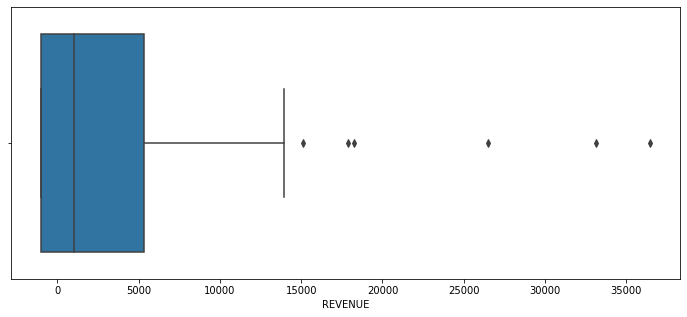

In [48]:
sb.boxplot(train['REVENUE'].sample(100))

In [ ]:
# Q1 = train.quantile(0.25)
# Q3 = train.quantile(0.75)
# IQR = Q3 - Q1
# IQR
# train = train[~((train < (Q1 - 1.5 * IQR)) |(train > (Q3 + 1.5 * IQR))).any(axis=1)]

In [ ]:
train.shape

(2154048, 15)

**The target heavily suffers from the challenge of data imbalance. This will be treated in later approaches** 

In [ ]:
train['CHURN'].value_counts()

0    1750062
1     403986
Name: CHURN, dtype: int64

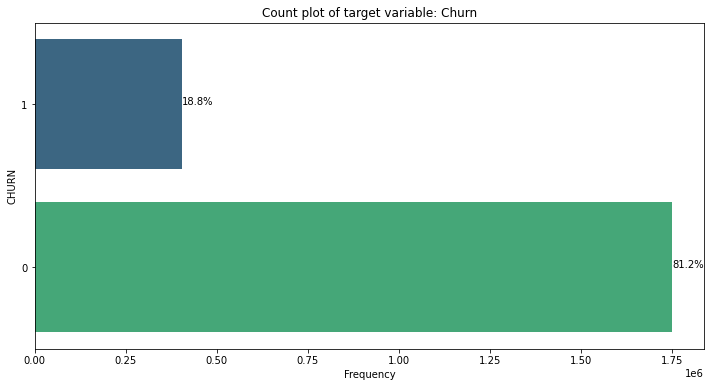

In [49]:
# visualize the count plot for the target variable: Churn
plt.figure(figsize=(12,6))
ax = sb.countplot(data= train, y = 'CHURN',order =train['CHURN'].value_counts(ascending=True).index, palette='viridis')
plt.title('Count plot of target variable: Churn')
plt.xlabel('Frequency')
total = len(train['CHURN'])
for p in ax.patches:
  percentage = '{:.1f}%'.format(100 * p.get_width()/total)
  x = p.get_x() + p.get_width() + 0.02
  y = p.get_y() + p.get_height()/2
  ax.annotate(percentage, (x, y))

plt.show()

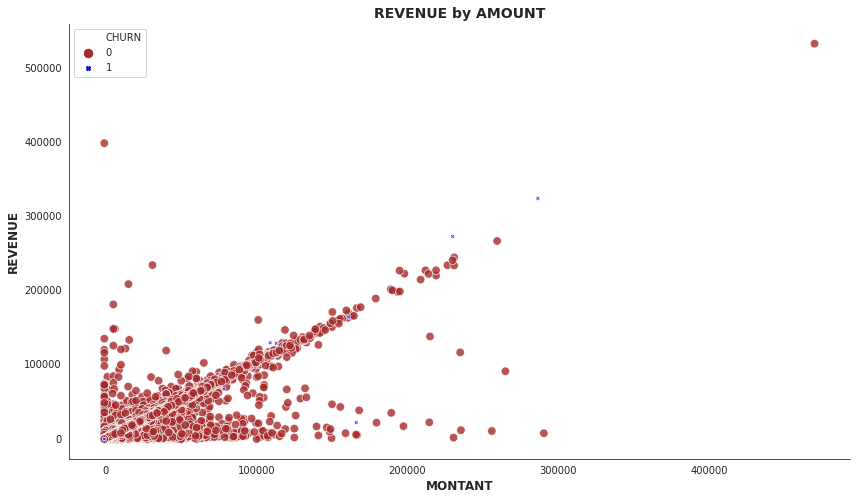

In [50]:
# Set initial plot options
sb.set_style('white')
plt.figure(figsize = (14, 8))

# Create scatterplot
sb.scatterplot(x = "MONTANT", y = "REVENUE", hue = "CHURN",size = "CHURN",  style = "CHURN", data = train, palette = ["brown", "blue"],alpha = 0.8)
# Despine plot
sb.despine()
# Final formatting touches
plt.xlabel("MONTANT", fontsize = 12, fontweight = "semibold")
plt.ylabel("REVENUE", fontsize = 12, fontweight = "semibold")
plt.title("REVENUE by AMOUNT", fontsize = 14, fontweight = "semibold")
plt.show()

**Fraom the scatter plot above, we can observe from the montant variable that there exist some huge amounts that are outliers and need to be capped at 250000 to exclude the rest.**

In [51]:
outlier = train[train['MONTANT'] > 250000.0].index.tolist()
train = train.drop(outlier)
train.shape

(2154042, 15)

**Visualize the correlation heatmap to identify relationships between variables**

We can observe that there exist a strong positive correlation between revenue and montant, also between montant ans arpu_segment, freuence and freq_rech also exhibited same strong relationships. On the other hand, revenue and montant indicate a weak negative relationship between themselves and the target ie. churn. However, we would need further analysis to determine the inclusion or exclusion of these variables in our final model.

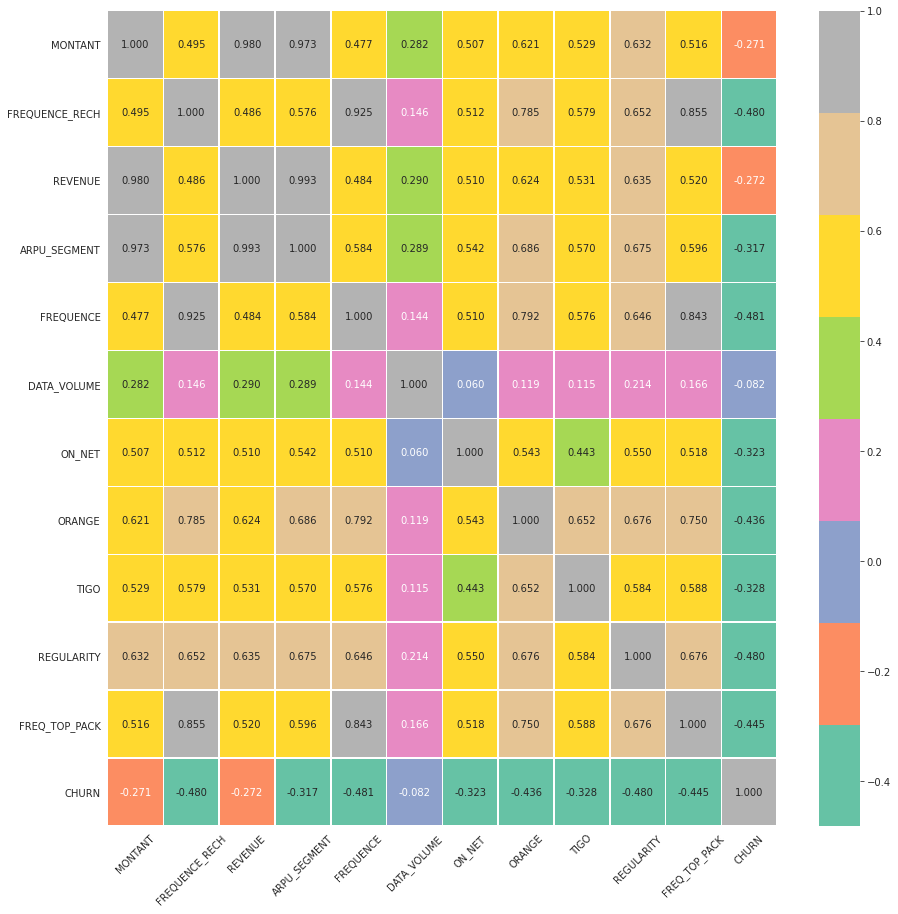

In [52]:
dfcor = train.corr()
fig = plt.figure(figsize=(15,15))
ax = sb.heatmap(dfcor,annot = True, fmt = ".3f", linewidths=0.5,cmap='Set2')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [53]:
count_no_churn = (train['CHURN'] == 0).sum()
print("Number of customers who didn't churn:",count_no_churn)
count_yes_churn = (train['CHURN']==1).sum()
print("Number of customers who churnes:",count_yes_churn)
pct_of_no_churn = count_no_churn/(count_no_churn+count_yes_churn)
print("percentage of customers who didn't churn:", pct_of_no_churn*100)
pct_of_yes_churn = count_yes_churn/(count_no_churn+count_yes_churn)
print("percentage of customers who churned:", pct_of_yes_churn*100)

Number of customers who didn't churn: 1750057
Number of customers who churnes: 403985
percentage of customers who didn't churn: 81.2452589132431
percentage of customers who churned: 18.754741086756894


## **MODELING USING CATBOOST CLASSIFIER**

**We will build our model with all the remaining features to understand the nature of the task and further adopt other techniques moving forward after the results from the model**

In [57]:
!pip install catboost

     |████████████████████████████████| 64.8MB 60kB/s 


In [58]:
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from catboost import CatBoostClassifier,Pool, cv
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score,log_loss
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Bayesian Optimization
# from ax.service.managed_loop import optimize

In [59]:
numeric_cols = ['MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT','FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO','REGULARITY', 'FREQ_TOP_PACK']
categorical_cols = ['REGION', 'TENURE', 'TOP_PACK']

**Creating pipepline objects**

In [60]:
# Chaining preprocessing into a Pipeline object
numeric_preprocessing_steps = Pipeline([('standard_scaler', StandardScaler()),('simple_imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator = True))])
categorical_preprocessing_steps = Pipeline([('simple_imputer', SimpleImputer(strategy='constant', fill_value='Missing', add_indicator = True)),('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers = [("numeric", numeric_preprocessing_steps, numeric_cols),('categorical', categorical_preprocessing_steps, categorical_cols)],remainder = "drop")

**Split train data into train and test**

In [61]:
from sklearn.model_selection import train_test_split
X = train.loc[:, train.columns != 'CHURN']
y = train.loc[:, train.columns == 'CHURN']
print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True,stratify=y,random_state=380 )
print('')
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Shape of X: (2154042, 14)
Shape of y: (2154042, 1)

Number transactions X_train dataset:  (1723233, 14)
Number transactions y_train dataset:  (1723233, 1)
Number transactions X_test dataset:  (430809, 14)
Number transactions y_test dataset:  (430809, 1)


In [62]:
# timer to check on time
def timer(start_time=None):
  if not start_time:
    start_time = datetime.now()
    return start_time
  elif start_time:
    thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
    tmin, tsec = divmod(temp_sec, 60)
    print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

**CatBoost Classifer Model**

In [63]:
# %%time
start_time = timer(None)
train_pipeline = Pipeline([("preprocessor", preprocessor),("estimator", CatBoostClassifier(learning_rate= 0.3, n_estimators= 700,random_seed=1024,verbose=100)),])
# Train model on train split and evaluate on test split
train_pipeline.fit(X_train, y_train)
# Predict on evaluation set
preds = train_pipeline.predict_proba(X_test)
print('Catboost Classifier log loss: {}'.format(log_loss(y_test, preds[:, 1])))
timer(start_time)

0:	learn: 0.3736040	total: 746ms	remaining: 8m 41s
100:	learn: 0.2508552	total: 1m 6s	remaining: 6m 35s
200:	learn: 0.2500321	total: 2m 11s	remaining: 5m 27s
300:	learn: 0.2493767	total: 3m 17s	remaining: 4m 21s
400:	learn: 0.2487919	total: 4m 22s	remaining: 3m 15s
500:	learn: 0.2482503	total: 5m 28s	remaining: 2m 10s
600:	learn: 0.2476174	total: 6m 34s	remaining: 1m 4s
699:	learn: 0.2471444	total: 7m 39s	remaining: 0us
Catboost Classifier log loss: 0.25058171789183314

 Time taken: 0 hours 7 minutes and 49.01 seconds.


**Predict on Test Data and submit**


In [64]:
# %%time 
start_time = timer(None)
# train on all data and predict on test
train_pipeline.fit(X,y)
test_probas = train_pipeline.predict_proba(test.drop('user_id', axis = 1))
# Save predictions to submission data frame
sample["CHURN"] = test_probas[:, 1]
sample.to_csv('HIMF_CatBB.csv', index=False)
timer(start_time)

0:	learn: 0.3673367	total: 887ms	remaining: 10m 20s
100:	learn: 0.2507254	total: 1m 23s	remaining: 8m 12s
200:	learn: 0.2499494	total: 2m 45s	remaining: 6m 49s
300:	learn: 0.2493615	total: 4m 7s	remaining: 5m 28s
400:	learn: 0.2488147	total: 5m 29s	remaining: 4m 5s
500:	learn: 0.2482875	total: 6m 52s	remaining: 2m 44s
600:	learn: 0.2478508	total: 8m 14s	remaining: 1m 21s
699:	learn: 0.2474155	total: 9m 36s	remaining: 0us

 Time taken: 0 hours 9 minutes and 49.85 seconds.


# **AFTER CLOSE OF COMPETITION:**

**best parameters with scores**

In [ ]:
# best parameters = {'l2_leaf_reg': 9, 'learning_rate': 0.13231494875853125, 'n_estimators': 700}# score --> 0.250764517072743
# learning_rate=0.3,n_estimators=500,l2_leaf_reg = 25,random_seed=1024,verbose=100 #               score  --> 0.250791380519741
# learning_rate=0.3,n_estimators=600,l2_leaf_reg = 25,random_seed=1024,verbose=100 #               score  --> 0.250804828847611
# # learning_rate=0.3,n_estimators=500,l2_leaf_reg = 27,random_seed=128,verbose=100 #              score  --> 0.250 854
# learning_rate=0.3,n_estimators=700,l2_leaf_reg = 27,random_seed=128,verbose=100 #                score --> 0.250854
# learning_rate=0.3,n_estimators=700,l2_leaf_reg = 30,random_seed=128,verbose=100 #                score  --> 0.250881
# learning_rate=0.3,n_estimators=1000 #                                                            score  --> 0.251024
# learning_rate=0.3,n_estimators=700,random_seed=1024,verbose=100 #                                score  --> 0.251024
# learning_rate=0.3,n_estimators=500,l2_leaf_reg = 25,random_seed=1024,verbose=100 # 

**Bayesian Optimization: Hyperparameter search**

In [ ]:
# def train_model(params):
#   train_pipeline = Pipeline([("preprocessor", preprocessor),
#                              ("estimator", CatBoostClassifier(verbose=50,n_estimators=params['n_estimators'],
#                                                               learning_rate=params['learning_rate'],
#                                                               depth = params["depth"],
#                                                               l2_leaf_reg=params['l2_leaf_reg'],loss_function='Logloss')),])
#   # train_pipeline.fit(X_train,y_train)
#   th = cross_validate(train_pipeline, X_train, y_train, cv=5,scoring=('accuracy', 'neg_log_loss'),return_train_score=True)
#   return -th['test_neg_log_loss'].mean()

# start_time = timer(None)
# best_parameters, values, experiment, gp_model = optimize(
#    parameters=[
#       {"name": "n_estimators", "type": "choice", "values": [10,20,50,100,200,300,400,500,600,700,800,900,1000]},
#       {"name": "depth", "type": "choice", "values": [3,5,6,7,9,11,12,13,15]},
#       {"name": "learning_rate", "type": "range", "bounds": [.1, 1.], "log_scale": True},
#       {"name": "l2_leaf_reg", "type": "choice", "values": [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
#        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]},
#    ],
#    evaluation_function=train_model,
#    objective_name='log_loss',
#    total_trials=20,
#    minimize=True,
# )
# timer(start_time)